In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Input, GlobalMaxPooling1D, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import joblib

In [2]:
train = pd.read_csv("twitter_training.csv")
test = pd.read_csv("twitter_validation.csv")

mengimport data yang kita punya menjadi data frame

In [3]:
train.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [5]:
train.shape

(74681, 4)

In [4]:
test.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [6]:
test.shape

(999, 4)

Karena pada train dan test tidak memiliki nama kolom / header maka akan ditambahkan 

In [7]:
train.columns =["twitterID", "company", "labels", "tweet"]
test.columns =["twitterID", "company", "labels", "tweet"]

In [8]:
train.head()

,twitterID,company,labels,tweet
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [9]:
test.head()

,twitterID,company,labels,tweet
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


Karena kita ingin membangun model untuk melakukan sentiment analysis. maka data company dan twitterID kita buang

In [10]:
train.drop(columns=["twitterID", "company"], inplace=True)
test.drop(columns=["twitterID", "company"], inplace=True)

In [11]:
train

,labels,tweet
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
74676,Positive,Just realized that the Windows partition of my...
74677,Positive,Just realized that my Mac window partition is ...
74678,Positive,Just realized the windows partition of my Mac ...
74679,Positive,Just realized between the windows partition of...


In [12]:
test

,labels,tweet
0,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Negative,@Microsoft Why do I pay for WORD when it funct...
2,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Neutral,Now the President is slapping Americans in the...
4,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...
994,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,Positive,Today sucked so it’s time to drink wine n play...
997,Positive,Bought a fraction of Microsoft today. Small wins.


berikutnya kita akan menggabungkan data test dengan train menjadi 1 

In [13]:
dataset = pd.concat([train, test], ignore_index=True)

In [14]:
dataset = dataset[dataset['labels'] != "Irrelevant"]
dataset

,labels,tweet
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
75673,Negative,Please explain how this is possible! How can t...
75674,Positive,Good on Sony. As much as I want to see the new...
75677,Positive,Today sucked so it’s time to drink wine n play...
75678,Positive,Bought a fraction of Microsoft today. Small wins.


kita melakukan pembersihan dataset terlebih dahulu seperti pengecheckan nilai null dan duplikasi data

In [15]:
dataset.isnull().sum()

labels      0
tweet     571
dtype: int64

In [16]:
dataset.dropna(inplace=True)
dataset.isnull().sum()

labels    0
tweet     0
dtype: int64

In [17]:
dataset.duplicated().sum()

4068

In [18]:
dataset.drop_duplicates(inplace=True)
dataset.duplicated().sum()

0

Berikutnya ada melakukan preprocessing data

In [19]:
lemma = WordNetLemmatizer()
stopwords = stopwords.words("english")

In [20]:
def cleaning_text(text):
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub(r'\W', ' ', str(text)) 
    text = re.sub(r'r\s+[a-zA-Z]\s+', ' ', text) 
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    
    words = word_tokenize(text)
    
    words = [lemma.lemmatize(word) for word in words]
    words = [word for word in words if word not in stopwords]
    words = [word for word in words if len(word) > 3]
    
    indices = np.unique(words, return_index=True)[1]
    cleaned_text = np.array(words)[np.sort(indices)].tolist()
    return cleaned_text

In [21]:
x = dataset.drop('labels', axis=1)
y = dataset.labels

In [22]:
texts = list(x['tweet'])

In [23]:
cleaned_text = [cleaning_text(text) for text in texts]

In [24]:
X_train, X_temp, y_train, y_temp = train_test_split(cleaned_text, y, test_size = 0.3, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [25]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)
word_idx = tokenizer.word_index
v = len(word_idx)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val = tokenizer.texts_to_sequences(X_val)

In [26]:
maxlen = 100
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)

In [27]:
d = 100

model = Sequential([
    Embedding(input_dim=v + 1, output_dim=d, input_length=maxlen),  
    Bidirectional(LSTM(150, return_sequences=False)),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

optimizer = Adam(learning_rate=0.01)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [28]:
le = LabelEncoder()
y_train_encode = le.fit_transform(y_train)
y_test_encode = le.transform(y_test)
y_val_encode = le.transform(y_val)

In [29]:
y_train_one_hot = tf.keras.utils.to_categorical(y_train_encode)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encode)
y_val_one_hot = tf.keras.utils.to_categorical(y_val_encode)

In [343]:
history = model.fit(X_train, y_train_one_hot, epochs=50, validation_data=(X_val, y_val_one_hot))

Epoch 1/50
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 166s 129ms/step - accuracy: 0.6261 - loss: 0.8132 - val_accuracy: 0.8459 - val_loss: 0.4041
Epoch 2/50
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 155s 122ms/step - accuracy: 0.8953 - loss: 0.2714 - val_accuracy: 0.8607 - val_loss: 0.3646
Epoch 3/50
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 191s 151ms/step - accuracy: 0.9219 - loss: 0.1978 - val_accuracy: 0.8712 - val_loss: 0.3552
Epoch 4/50
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 205s 162ms/step - accuracy: 0.9313 - loss: 0.1713 - val_accuracy: 0.8654 - val_loss: 0.3937
Epoch 5/50
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 204s 161ms/step - accuracy: 0.9364 - loss: 0.1617 - val_accuracy: 0.8816 - val_loss: 0.3518
Epoch 6/50
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 188s 149ms/step - accuracy: 0.9384 - loss: 0.1540 - val_accuracy: 0.8738 - val_loss: 0.3717
Epoch 7/50
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 202s 160ms/step - accuracy: 0.9436 - loss: 0.1446 - val_accuracy: 0.8800 - val_loss: 0.3879
Epoch 8/50
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 199s 157ms/step - ac

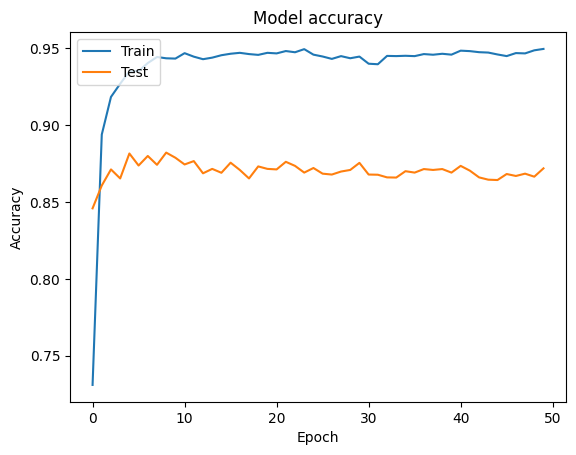

In [344]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

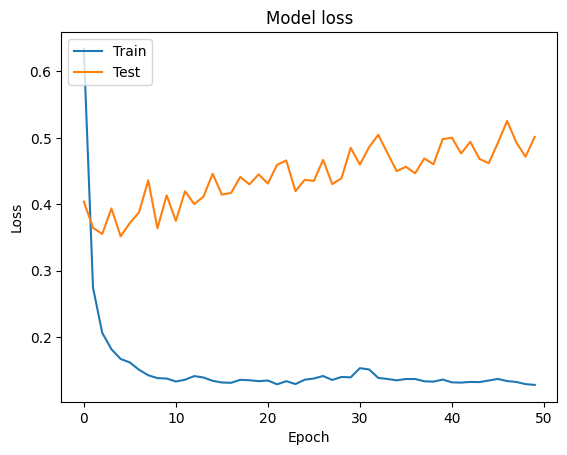

In [345]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [32]:
loss, accuracy = model.evaluate(X_test, y_test_one_hot)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

272/272 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8693 - loss: 0.5244
Test Loss: 0.5219520330429077
Test Accuracy: 0.8721492886543274


In [347]:
joblib.dump(model, 'lstm.joblib')
joblib.dump(le, "label_encoder.joblib")
joblib.dump(tokenizer, "tokenizer.joblib")

['tokenizer.joblib']

In [30]:
model = joblib.load("lstm.joblib")

In [31]:
predictions = model.predict(X_test)

if predictions.ndim > 1:
    predictions = predictions.argmax(axis = 1)
    
predictions = le.inverse_transform(predictions)

predictions_values = list(predictions)
actual_values = list(y_test)

print("Actual                   Predictions")
print("====================================")
for (predict, actual) in zip(predictions_values, actual_values):
    print(f"{actual}                    {predict}")

272/272 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step
Actual                   Predictions
Positive                    Positive
Positive                    Positive
Negative                    Negative
Negative                    Negative
Neutral                    Neutral
Negative                    Neutral
Positive                    Positive
Negative                    Negative
Positive                    Positive
Positive                    Positive
Positive                    Positive
Negative                    Negative
Negative                    Negative
Positive                    Positive
Positive                    Positive
Positive                    Negative
Neutral                    Negative
Negative                    Negative
Neutral                    Neutral
Neutral                    Neutral
Negative                    Negative
Negative                    Negative
Negative                    Positive
Negative                    Negative
Neutral                    Neutral
Negat

272/272 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step


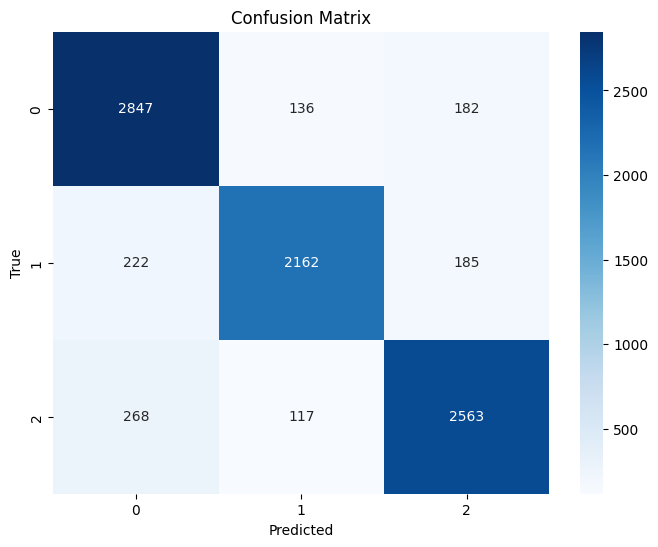

In [351]:
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test_one_hot, axis=1)
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()